In [37]:
import numpy as np
import os
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from osgeo import gdal
import sys
import signal
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from skimage.util.shape import view_as_windows
from scipy.stats import mode
from tqdm import tqdm
from utils import extract_patches, load_train_data, load_classes,\
    labels2groups, pixels2histogram
import matplotlib.pyplot as plt
from utils import load_tif_image, extract_training_patches, extract_testing_patches,\
    categories_to_rgb, rgb_to_categories, plot_classes_histogram, balance_dataset, create_block_index_matrix,\
        reconstruct_patches, reconstruct_reduced_patches
import re
import argparse
import matplotlib.patches as mpatches
import os
from skimage.color import rgb2gray
from skimage.io import imread
from numpy.fft import fft2, fftshift
import cv2

In [61]:
train_filenames_label = ['top_potsdam_2_14_RGBIR.tif', 'top_potsdam_6_12_RGBIR.tif', 'top_potsdam_5_13_RGBIR.tif']

img_path = os.path.join('data/Potsdam/4_Ortho_RGBIR', 'top_potsdam_2_14_RGBIR.tif')

img = load_tif_image(img_path).transpose(1, 2, 0)[:, :, :3]
print(img.shape)

Warning 1: data/Potsdam/4_Ortho_RGBIR/top_potsdam_2_14_RGBIR.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(6000, 6000, 3)


In [38]:
def apply_low_pass_filter(image, cutoff_radius):
    """
    Aplica um filtro passa-baixa a uma imagem usando a FFT.

    Args:
        image (numpy.ndarray): Imagem em escala de cinza.
        cutoff_radius (int): Raio do filtro passa-baixa.

    Returns:
        numpy.ndarray: Imagem filtrada no domínio do espaço.
    """
    # Transformada de Fourier 2D
    dft = np.fft.fft2(image)
    dft_shifted = np.fft.fftshift(dft)

    # Criação do filtro passa-baixa
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Coordenadas do centro

    # Criação de uma máscara circular
    mask = np.zeros((rows, cols), dtype=np.uint8)
    cv2.circle(mask, (ccol, crow), cutoff_radius, 1, -1)

    # Aplicação da máscara no domínio da frequência
    filtered_dft = dft_shifted * mask

    # Transformada Inversa para voltar ao domínio do espaço
    filtered_dft_shifted = np.fft.ifftshift(filtered_dft)
    filtered_image = np.fft.ifft2(filtered_dft_shifted)
    filtered_image = np.abs(filtered_image)

    return filtered_image

float64
21.095449043527452 193.74585483805132
21 193


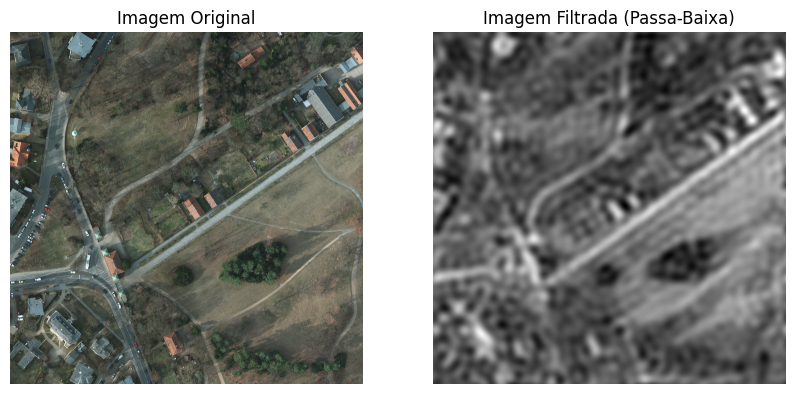

In [56]:
# Aplicar o filtro passa-baixa
cutoff_radius = 30  # Ajuste o raio conforme necessário
filtered_image = apply_low_pass_filter(cv2.cvtColor(img[:, :, ::-1], cv2.COLOR_BGR2GRAY), cutoff_radius)
print(filtered_image.dtype)
print(filtered_image.min(), filtered_image.max())
filtered_image = (filtered_image).astype(np.uint8)
print(filtered_image.min(), filtered_image.max())

# Visualizar o resultado
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Imagem Filtrada (Passa-Baixa)")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.show()

In [58]:
for filename in train_filenames_label:
    img_path = os.path.join('data/Potsdam/4_Ortho_RGBIR', filename)
    img = load_tif_image(img_path).transpose(1, 2, 0)
    print(img.shape)
    image = rgb2gray(img[:, :, :3])

    fft_result = fft2(image)
    fft_shifted = fftshift(fft_result)  # Centraliza a frequência baixa no centro

    magnitude = np.abs(fft_shifted)
    phase = np.angle(fft_shifted)
    
    print(magnitude.shape)
    print(phase.shape)
    
    # np.save('data/Potsdam/RGB_Fourier/magnitude_' + filename[:-4], magnitude)
    # np.save('data/Potsdam/RGB_Fourier/phase_' + filename[:-4], phase)
    
    # Save in png
    # plt.imsave('data/Potsdam/RGB_Fourier/magnitude_' + filename[:-4] + '.png', magnitude, cmap='gray')
    # plt.imsave('data/Potsdam/RGB_Fourier/phase_' + filename[:-4] + '.png', phase, cmap='gray')
    
    np.save('data/Potsdam/RGB_Fourier/magnitude_' + filename[:-4] + '.npy', magnitude)
    np.save('data/Potsdam/RGB_Fourier/phase_' + filename[:-4] + '.npy', phase)  
    
    gray = cv2.cvtColor(img[:, :, ::-1], cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=150, threshold2=250, apertureSize=3, L2gradient=True)
    # plt.imsave('data/Potsdam/Edges/canny_' + filename[:-4] + '.png', edges, cmap='gray')
    np.save('data/Potsdam/Edges/canny_' + filename[:-4] + '.npy', edges)
    
    nir = img[:, :, 3]
    red = img[:, :, 0]
    # Calcular o NDVI
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
        ndvi[np.isnan(ndvi)] = 0  # Substituir NaN por 0
        ndvi[np.isinf(ndvi)] = 0  # Substituir Inf por 0

    # Normalizar o NDVI para o intervalo de 0 a 255 para visualização
    ndvi_normalized = ((ndvi - ndvi.min()) / (ndvi.max() - ndvi.min()))
    # ndvi = (nir - red) / (nir + red)
    print(ndvi.shape)
    # plt.imsave('data/Potsdam/NDVI/ndvi_' + filename[:-4] + '.png', ndvi, cmap='gray')
    np.save('data/Potsdam/NDVI/ndvi_normalized_' + filename[:-4] + '.npy', ndvi_normalized)
    

Warning 1: data/Potsdam/4_Ortho_RGBIR/top_potsdam_2_14_RGBIR.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(6000, 6000, 4)
(6000, 6000)
(6000, 6000)
(6000, 6000)


Warning 1: data/Potsdam/4_Ortho_RGBIR/top_potsdam_6_12_RGBIR.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(6000, 6000, 4)
(6000, 6000)
(6000, 6000)
(6000, 6000)


Warning 1: data/Potsdam/4_Ortho_RGBIR/top_potsdam_5_13_RGBIR.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(6000, 6000, 4)
(6000, 6000)
(6000, 6000)
(6000, 6000)


Warning 1: data/Potsdam/4_Ortho_RGBIR/top_potsdam_2_14_RGBIR.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/tmp/ipykernel_11856/2588087445.py:5: RuntimeWarning: divide by zero encountered in divide
  ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
/tmp/ipykernel_11856/2588087445.py:5: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)


(6000, 6000)
0.0 1.0 0.2807096127845912


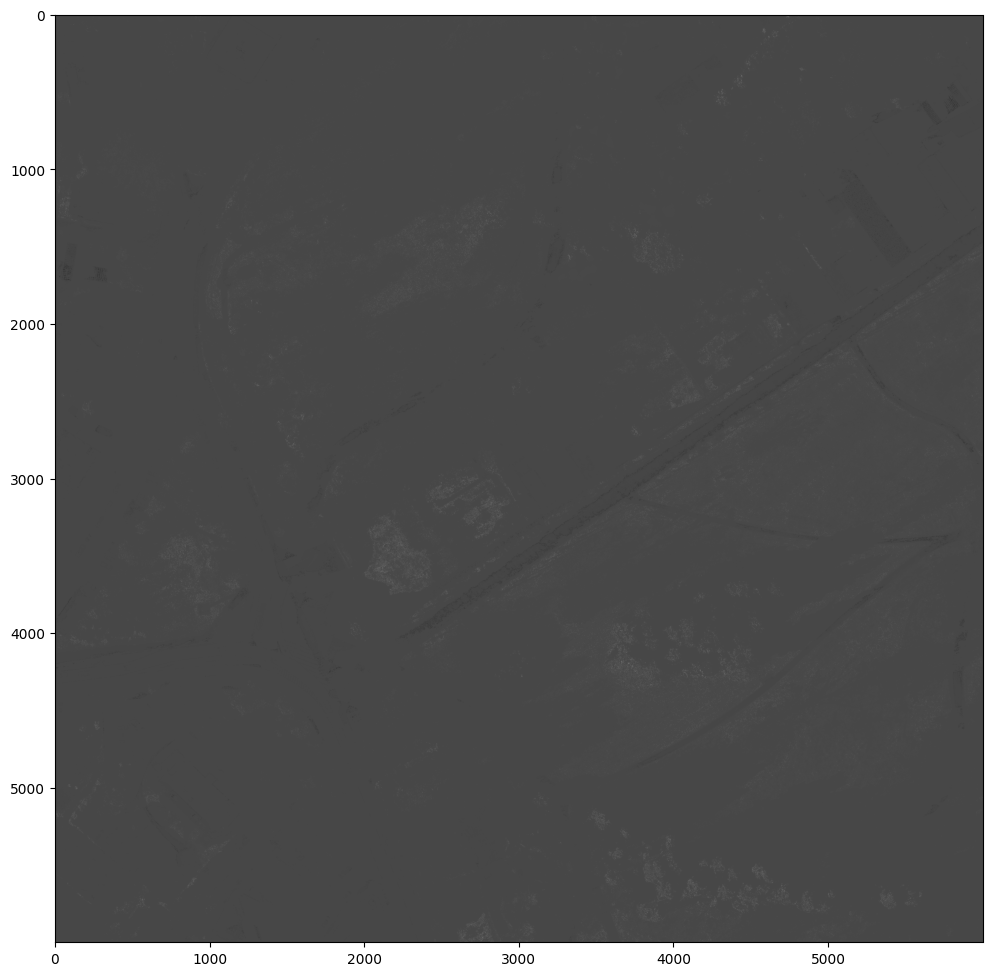

In [68]:
# Load ndvi png file
img2 = load_tif_image(img_path).transpose(1, 2, 0)
nir = img2[:, :, 3]
red = img2[:, :, 0]
ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
ndvi[np.isnan(ndvi)] = 0  # Substituir NaN por 0
ndvi[np.isinf(ndvi)] = 0  # Substituir Inf por 0
ndvi_normalized = ((ndvi - ndvi.min()) / (ndvi.max() - ndvi.min()))

# Visualize the NDVI
print(ndvi.shape)
print(ndvi_normalized.min(), ndvi_normalized.max(), ndvi_normalized.mean())
plt.figure(figsize=(10, 10))
plt.imshow(ndvi_normalized, cmap='gray')
plt.tight_layout()
plt.show()

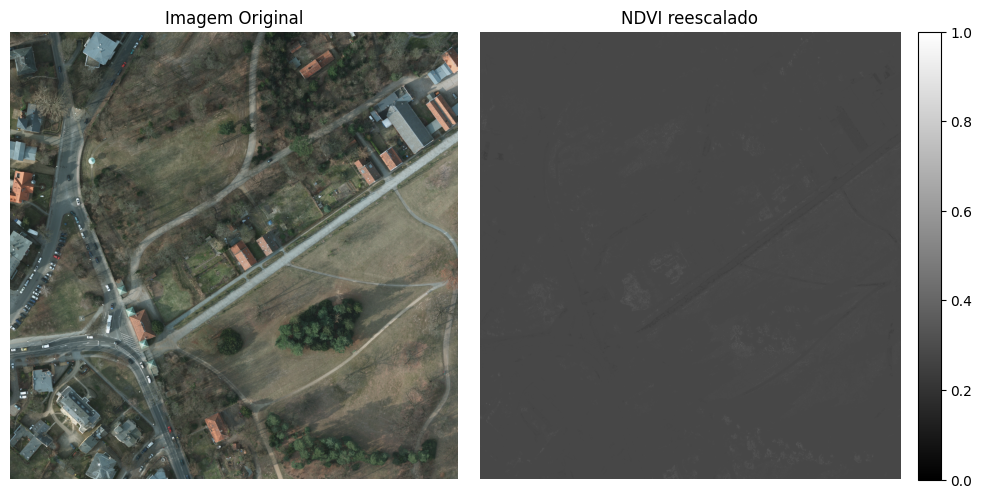

In [86]:
# Configura a figura e os subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot da primeira imagem (colorida)
axes[0].imshow(img2[:, :, :3])
axes[0].axis('off')  # Remove os eixos
axes[0].set_title('Imagem Original')

# Plot da segunda imagem (grayscale) com barra de cores
cax = axes[1].imshow(ndvi_normalized, cmap='gray', vmin=0, vmax=1, aspect='auto')
axes[1].axis('off')  # Remove os eixos
axes[1].set_title('NDVI reescalado')

# Adiciona a barra de cores
fig.colorbar(cax, ax=axes[1], fraction=0.05, pad=0.04)

# Mostra o resultado
plt.tight_layout()
plt.show()

fig.savefig('data/Potsdam/ndvi_tr1.png', dpi=300)


In [7]:
print(magnitude.shape)
print(phase.shape)

(6000, 6000)
(6000, 6000)


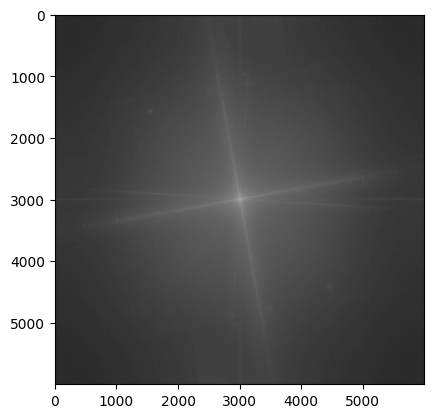

In [27]:
plt.imshow(np.log(magnitude + 1), cmap='gray')
plt.show()

(6000, 6000) uint8


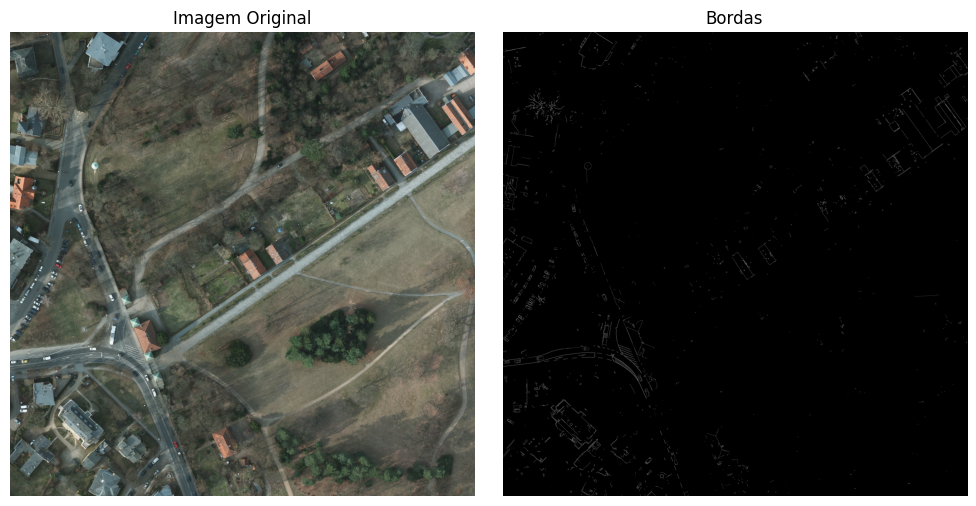

In [60]:

# # Carregar uma imagem do dataset Potsdam
# image_path = "potsdam_image.tif"  # Substitua pelo caminho da imagem
# image = cv2.imread(img_path, cv2.IMREAD_COLOR)

# Converter para escala de cinza
gray = cv2.cvtColor(img[:, :, ::-1], cv2.COLOR_BGR2GRAY)

# Apply a laplacian filter before edge detection
# laplacian = cv2.Laplacian(gray, cv2.CV_64F)
# gray = cv2.convertScaleAbs(laplacian)


# Apply a low pass blur filter before edge detection
gray = cv2.GaussianBlur(gray, (5, 5), 0)


print(filtered_image.shape, filtered_image.dtype)
# Aplicar o detector de bordas Canny
edges = cv2.Canny(gray, threshold1=100, threshold2=200, apertureSize=3, L2gradient=True)

# Plotar a imagem original e as bordas detectadas
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Bordas")
plt.axis('off')

plt.tight_layout()
plt.show()
# Visualizar as bordas
# fig = plt.figure(1, 2, figsize=(10, 8))
# plt.imshow(edges, cmap='gray')
# plt.title("Bordas detectadas (Canny)")
# plt.axis('off')
# plt.show()
fig.savefig('data/Potsdam/canny_top_potsdam_2_14_RGBIR.png')



In [21]:
# Load IRRG, DSM and labels
img_path = os.path.join('data/Potsdam/3_Ortho_IRRG', 'top_potsdam_5_13_IRRG.tif')
img = load_tif_image(img_path).transpose(1, 2, 0)

dsm = load_tif_image('data/Potsdam/1_DSM_normalisation/dsm_potsdam_05_13_normalized_lastools.jpg')

labels = load_tif_image('data/Potsdam/5_Labels_all/top_potsdam_5_13_label.tif').transpose(1, 2, 0)

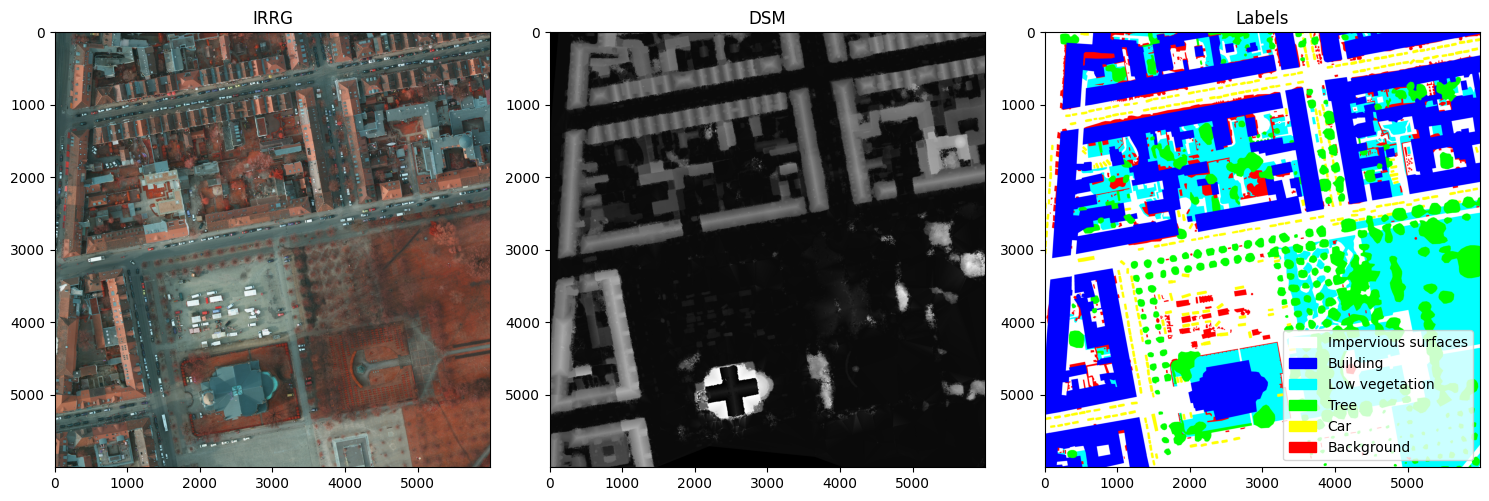

In [22]:
# Plot IRRG, DSM and labels side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title('IRRG')
ax[1].imshow(dsm, cmap='gray')
ax[1].set_title('DSM')
ax[2].imshow(labels)
ax[2].set_title('Labels')
map_rgb2cat = {(255, 255, 255): 0, (0, 0, 255): 1, (0, 255, 255): 2, (0, 255, 0): 3, (255, 255, 0): 4, (255, 0, 0): 5}
label_names = ['Impervious surfaces', 'Building', 'Low vegetation', 'Tree', 'Car', 'Background']
# Create a legend for the labels
patches = [mpatches.Patch(color=np.array(key) / 255, label=label_names[val]) for key, val in map_rgb2cat.items()]
plt.legend(handles=patches, loc='lower right')
plt.tight_layout()
plt.show()
fig.savefig('data/Potsdam/RGBIR_DSM_Labels_tst.png', dpi=300)


In [26]:
def create_block_index_matrix(image_shape, block_size):
    # Obtenha os índices das posições dos elementos
    indices = np.indices(image_shape[:2])
    # indices = np.arange(0, image_shape[0] * image_shape[1], 1).reshape(image_shape[:2])
    # print(indices.shape)
    # return indices
    # 1/0
    
    # Divida os índices pelo tamanho do bloco para obter os índices dos blocos
    block_indices = indices // block_size
    
    # Combine os índices dos blocos para obter um índice único para cada bloco
    block_matrix = block_indices[0] * (image_shape[1] // block_size) + block_indices[1]
    
    return block_matrix

0 0 1 23 0


ZeroDivisionError: division by zero

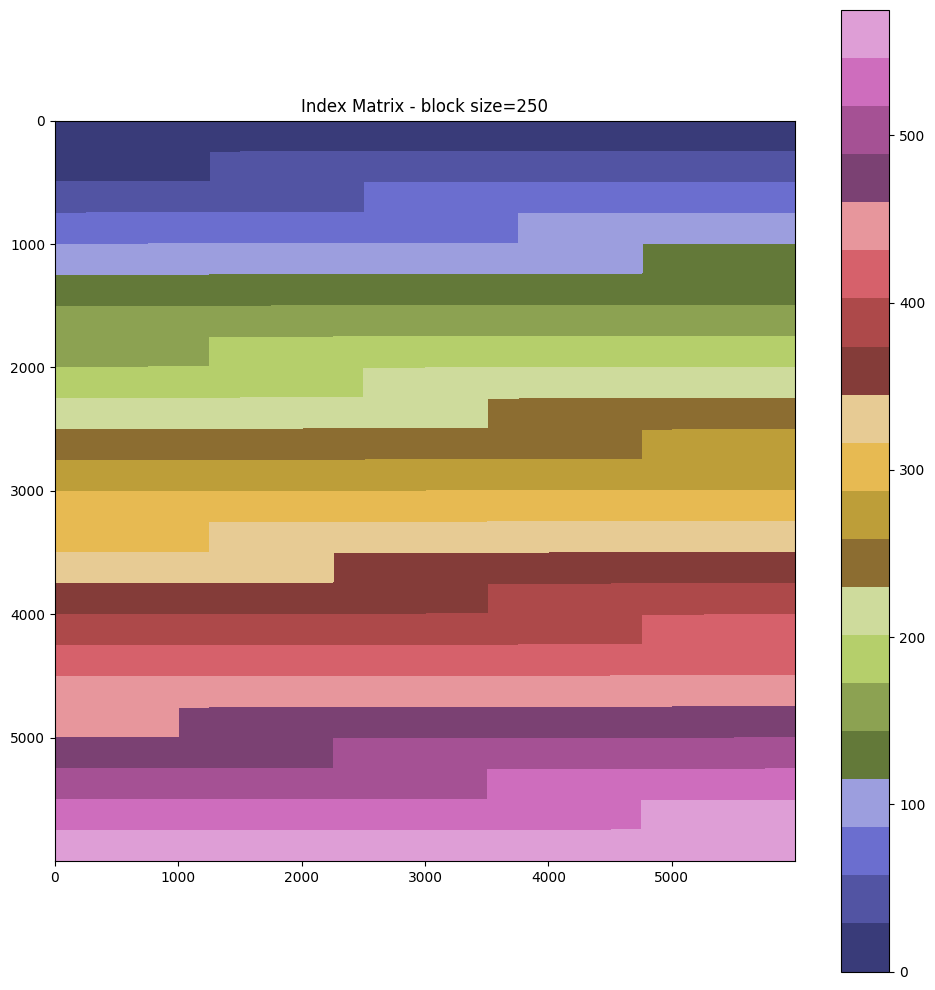

In [ ]:
# Load index matrix
block_size = 250
index_matrix = create_block_index_matrix((6000, 6000), block_size)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(index_matrix, cmap='tab20b')
plt.colorbar()
plt.title(f'Index Matrix - block size={block_size}')
plt.tight_layout()
print(index_matrix[0, 0], index_matrix[0, 1], index_matrix[0, 251], index_matrix[0, 5999], index_matrix[1, 0])
plt.show()
fig.savefig(f'data/Potsdam/index_matrix_block_size={block_size}.png', dpi=300)
